# Experiments with real data (Bikes)

https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition

## Requirements

In [8]:
import os, sys, pickle
import polars as pl
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
from BigEDA.descriptive import outliers_table, summary
from BigEDA.plots import boxplot_matrix, histogram_matrix, barplot_matrix, ecdfplot_matrix
from datetime import datetime
from zoneinfo import ZoneInfo  
from tqdm import tqdm
import random
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import pandas as pd
from PyDistances.mixed import FastGGowerDistMatrix
from sklearn.manifold import MDS
from FastKmedoids.plots import clustering_MDS_plot_multiple_methods
from FastKmedoids.models import FastKmedoidsGGower, FoldFastKmedoidsGGower
from sklearn_extra.cluster import KMedoids, CLARA
from sklearn.cluster import (KMeans, AgglomerativeClustering,
                             SpectralClustering, SpectralBiclustering, SpectralCoclustering, Birch, 
                             BisectingKMeans, MiniBatchKMeans)
from sklearn.mixture import GaussianMixture
from clustpy.partition import SubKmeans, LDAKmeans, DipInit
from clustpy.hierarchical import Diana

sns.set_style('whitegrid')

current_path = os.getcwd()
data_path = os.path.join(current_path, '..', '..', 'data')
data_filename = 'uci_heart_disease_processed.pkl'
data_file_path = os.path.join(data_path, data_filename)

src_path = os.path.join(current_path, '..', '..', 'src')
config_path = os.path.join(current_path, '..',  '..', 'config')

sys.path.append(src_path)
sys.path.append(config_path)

from experiments_utils import (make_experiment_1, 
                               make_experiment_3, 
                               make_experiment_4,
                               get_pivoted_results, get_avg_results,
                               get_pivoted_results_two_iterables,
                               get_avg_results_two_iterables,
                               avg_results_to_dfs,
                               get_GGower_distances_names,
                               split_list_in_chunks)

from config_experiment_1_bikes import get_config as get_config_exp_1_bikes
from config_experiment_3_bikes import get_config as get_config_exp_3_bikes
from config_experiment_4_bikes import get_config as get_config_exp_4_bikes

---


| Variable | Descripción | Rol | Tipo de Dato | Valores / Unidades |
| :--- | :--- | :--- | :--- | :--- |
| **cnt** | Conteo de **alquileres totales** de bicicletas (`casual` + `registered`). | **Target** | Numérica (entera) | Conteo de bicicletas. |
| **temp** | Temperatura normalizada en Celsius. | Feature | Numérica (continua) | Normalizada: $(t - t_{min})/(t_{max} - t_{min})$($t_{min} = -8$, $t_{max} = 39$). |
| **atemp** | Sensación térmica normalizada en Celsius. | Feature | Numérica (continua) | Normalizada: $(t - t_{min})/(t_{max} - t_{min})$($t_{min} = -16$, $t_{max} = 50$). |
| **windspeed** | Velocidad del viento normalizada. | Feature | Numérica (continua) | Normalizada (dividida por 67, max). |
| **season** | Estación del año. | Feature | Categórica (nominal) | `1`: Invierno, `2`: Primavera, `3`: Verano, `4`: Otoño. |
| **yr** | Año. | Feature | Categórica (nominal) | `0`: 2011, `1`: 2012, ..., `7`: 2018. |
| **mnth** | Mes. | Feature | Categórica (nominal) | 1 a 12. |
| **hr** | Hora del día (0 a 23). (Solo en datos por hora) | Feature | Categórica (nominal) | 0 a 23. |
| **holiday** | Indicador de día festivo. | Feature | **Binaria** | 0: No festivo, 1: Festivo. |
| **weekday** | Día de la semana. | Feature | Categórica (nominal) | 0 a 6 (ej. `0`: Domingo). |
| **workingday**| Indicador de si el día no es fin de semana ni festivo. | Feature | **Binaria** | 1: Día laborable, 0: Fin de semana o festivo. |
| **casual** | Conteo de usuarios casuales (no registrados). | Other | Numérica (entera) | Conteo de usuarios. |
| **registered**| Conteo de usuarios registrados. | Other | Numérica (entera) | Conteo de usuarios. |
| **dteday** | Fecha del registro. | Feature | Fecha | Fecha. |
| **AWND** | Velocidad promedio diaria del viento. | Feature | Numérica (continua) | Millas por hora (miles per hour). |
| **PRCP** | Precipitación. | Feature | Numérica (continua) | Pulgadas (inches a centésimas). |
| **TMAX** | Temperatura máxima diaria. | Feature | Numérica (entera) | Fahrenheit. |
| **TMIN** | Temperatura mínima diaria. | Feature | Numérica (entera) | Fahrenheit. |
| **Dewpt** | Temperatura media diaria. | Feature | Numérica (continua) | Celsius (Mean daily temperature). |
| **RHx** | Humedad relativa. | Feature | Numérica (continua) | Porcentaje (in %). |
| **Height** | Altura del techo / Cielo raso. | Feature | Numérica (continua) | Metros (meters). |
| **Visby** | Visibilidad. | Feature | Numérica (continua) | Unidades no especificadas (podría ser metros o millas). |
| **Slp** | Presión del nivel del mar. | Feature | Numérica (continua) | hPa (Hectopascales). |

In [9]:
data_filename = 'bikes.xlsx'
data_file_path = os.path.join(data_path, data_filename)

import polars as pl

In [10]:
df = pl.read_excel(data_file_path)

In [11]:
df

dteday,season,yr,mnth,holiday,weekday,workingday,AWND,PRCP,TMAX,TMIN,WindSpeed,Height,Visby,Temp,Dewpt,Slp,RHx,casual,registered,cnt,yrmo,Atemp
date,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,str,f64
2011-01-01,1,0,1,0,6,0,7.16,0.01,58,34,2.719,12000.647,14949.324,7.484,3.892,1019.853,78.162,331,654,985,"""201101""",12.028
2011-01-02,1,0,1,0,0,0,10.96,0.06,59,34,4.665,1101.211,14220.0,11.163,7.928,1015.731,81.37,131,670,801,"""201101""",10.356
2011-01-03,1,0,1,0,1,1,10.29,0.0,41,28,5.412,22000.0,16069.75,1.688,-10.316,1023.331,41.156,120,1229,1349,"""201101""",-2.483
2011-01-04,1,0,1,0,2,1,6.49,0.0,43,25,3.084,15420.036,16069.75,0.494,-6.725,1018.384,58.938,108,1454,1562,"""201101""",-2.353
2011-01-05,1,0,1,0,3,1,8.5,0.0,43,31,3.506,19603.333,16069.75,2.694,-8.387,1013.812,45.562,82,1518,1600,"""201101""",0.486
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2019-02-24,1,8,2,0,0,0,11.18,0.94,63,39,3.938,2158.458,10903.786,5.954,3.396,1009.462,84.519,809,4389,5198,"""201902""",4.175
2019-02-25,1,8,2,0,1,1,18.34,0.0,51,41,8.722,22000.0,16069.75,8.213,-12.544,1013.728,22.031,239,5683,5922,"""201902""",4.523
2019-02-26,1,8,2,0,2,1,8.5,0.0,53,34,3.706,15171.179,16069.75,6.447,-11.922,1027.884,26.281,391,7169,7560,"""201902""",4.112


In [12]:
df = df.drop_nulls()

In [13]:
response = 'cnt'
excluded_variables = ['casual', 'registered', 'dteday', 'yrmo']
predictors = [col for col in df.columns if col not in excluded_variables + [response]]

In [14]:
cat_predictors = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday']
quant_predictors = [col for col in predictors if col not in cat_predictors]
binary_predictors = [col for col in cat_predictors if len(df[col].unique()) == 2]
multiclass_predictors = [col for col in cat_predictors if col not in binary_predictors]

p1 = len(quant_predictors)
p2 = len(binary_predictors)
p3 = len(multiclass_predictors)

In [15]:
q25 = df[response].quantile(0.25)
q75 = df[response].quantile(0.75)
#mean = df[response].mean()

'''
df = df.with_columns(pl.col(response).cut(
    breaks=[q75],
    labels=[
        'low',
        'high'
    ],
    left_closed=True
))
'''

df = df.with_columns(pl.col(response).cut(
    breaks=[q25, q75],
    labels=[
        'low',
        'medium',
        'high'
    ],
    left_closed=True
))

In [16]:
encoding = {}

'''
encoding[response] = {
    'low': 0,
    'high': 1         
}
'''

encoding[response] = {
    'low': 0,
    'medium': 1,
    'high': 2         
}

for col in encoding: 
    df = df.with_columns(pl.col(col).replace_strict(encoding[col]).alias(col))

In [17]:
X = df[quant_predictors + binary_predictors + multiclass_predictors]
y = df[response]

In [18]:
output = {
    'df': df, 
    'X': X, 
    'y': y, 
    'p1': p1, 
    'p2': p2, 
    'p3': p3,
    'encoding': encoding,
    'quant_predictors': quant_predictors,
    'binary_predictors': binary_predictors,
    'multiclass_predictors': multiclass_predictors
}

In [19]:
n_clusters = len(y.unique())

---

In [20]:
df.describe()

statistic,dteday,season,yr,mnth,holiday,weekday,workingday,AWND,PRCP,TMAX,TMIN,WindSpeed,Height,Visby,Temp,Dewpt,Slp,RHx,casual,registered,cnt,yrmo,Atemp
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64
"""count""","""2962""",2962.0,2962.0,2962.0,2962.0,2962.0,2962.0,2962.0,2962.0,2962.0,2962.0,2962.0,2962.0,2962.0,2962.0,2962.0,2962.0,2962.0,2962.0,2962.0,2962.0,"""2962""",2962.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0
"""mean""","""2015-01-24 22:31:01.985000""",2.495949,3.575287,6.420324,0.030385,2.996286,0.68366,8.36475,0.118606,67.926739,51.279541,3.769008,10205.021291,14857.942662,15.045662,7.539074,1017.868317,63.70531,1645.063471,6000.334909,1.000338,null,14.665623
"""std""",null,1.115191,2.354995,3.488956,0.171673,2.000419,0.465126,3.334767,0.339893,18.100335,16.993836,1.495345,6559.652899,2245.630568,9.490675,10.469102,6.95547,14.914003,1554.305079,2722.483581,0.707226,null,10.903006
"""min""","""2011-01-01""",1.0,0.0,1.0,0.0,0.0,0.0,1.12,0.0,19.0,5.0,0.517,85.65,2177.061,-10.631,-23.55,985.383,16.788,2.0,20.0,0.0,"""201101""",-18.37
"""25%""","""2013-01-10""",1.0,2.0,3.0,0.0,1.0,0.0,6.04,0.0,53.0,37.0,2.724,4381.024,14662.976,7.044,-0.725,1013.403,52.344,481.0,3843.0,1.0,null,6.302
"""50%""","""2015-01-21""",2.0,4.0,6.0,0.0,3.0,1.0,7.83,0.0,69.0,51.0,3.592,9626.344,16069.75,15.318,8.527,1017.528,64.0,1181.0,5941.0,1.0,null,15.524
"""75%""","""2017-02-05""",3.0,6.0,9.0,0.0,5.0,1.0,10.29,0.04,84.0,67.0,4.571,15608.893,16069.75,23.776,16.892,1022.156,74.939,2309.0,8097.0,2.0,null,23.916
"""max""","""2019-02-28""",4.0,8.0,12.0,1.0,6.0,1.0,29.97,4.0,105.0,84.0,11.361,22000.0,16093.0,33.762,24.878,1041.444,99.082,10173.0,12464.0,2.0,"""201902""",40.49


In [21]:
X

AWND,PRCP,TMAX,TMIN,WindSpeed,Height,Visby,Temp,Dewpt,Slp,RHx,Atemp,holiday,workingday,season,yr,mnth,weekday
f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64
7.16,0.01,58,34,2.719,12000.647,14949.324,7.484,3.892,1019.853,78.162,12.028,0,0,1,0,1,6
10.96,0.06,59,34,4.665,1101.211,14220.0,11.163,7.928,1015.731,81.37,10.356,0,0,1,0,1,0
10.29,0.0,41,28,5.412,22000.0,16069.75,1.688,-10.316,1023.331,41.156,-2.483,0,1,1,0,1,1
6.49,0.0,43,25,3.084,15420.036,16069.75,0.494,-6.725,1018.384,58.938,-2.353,0,1,1,0,1,2
8.5,0.0,43,31,3.506,19603.333,16069.75,2.694,-8.387,1013.812,45.562,0.486,0,1,1,0,1,3
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
11.18,0.94,63,39,3.938,2158.458,10903.786,5.954,3.396,1009.462,84.519,4.175,0,0,1,8,2,0
18.34,0.0,51,41,8.722,22000.0,16069.75,8.213,-12.544,1013.728,22.031,4.523,0,1,1,8,2,1
8.5,0.0,53,34,3.706,15171.179,16069.75,6.447,-11.922,1027.884,26.281,4.112,0,1,1,8,2,2


In [22]:
p3

4

In [23]:
n_clusters

3

In [24]:
y.value_counts()

cnt,count
i64,u32
2,741
0,740
1,1481


In [25]:
outliers_df = outliers_table(X, auto=False, col_names=quant_predictors, h=1.5)
outliers_df

quant_variables,lower_bound,upper_bound,n_outliers,n_not_outliers,prop_outliers,prop_not_outliers
str,f64,f64,i64,i64,f64,f64
"""AWND""",-0.335,16.665,62,2900,0.020932,0.979068
"""PRCP""",-0.06,0.1,578,2384,0.195138,0.804862
"""TMAX""",6.5,130.5,0,2962,0.0,1.0
"""TMIN""",-8.0,112.0,0,2962,0.0,1.0
"""WindSpeed""",-0.0465,7.3415,77,2885,0.025996,0.974004
…,…,…,…,…,…,…
"""Temp""",-18.054,48.874,0,2962,0.0,1.0
"""Dewpt""",-27.1505,43.3175,0,2962,0.0,1.0
"""Slp""",1000.2735,1035.2855,53,2909,0.017893,0.982107


In [26]:
outliers_df['prop_outliers'].mean()

0.03291694800810264

In [27]:
# Correlation Matrix
X[quant_predictors].to_pandas().corr()

,AWND,PRCP,TMAX,TMIN,WindSpeed,Height,Visby,Temp,Dewpt,Slp,RHx,Atemp
AWND,1.000000,0.090845,-0.194529,-0.198528,0.923582,-0.065799,-0.029756,-0.167134,-0.200131,-0.297969,-0.149933,-0.234329
PRCP,0.090845,1.000000,0.025450,0.087710,0.103525,-0.367105,-0.497438,0.060472,0.176997,-0.171573,0.372736,0.058684
TMAX,-0.194529,0.025450,1.000000,0.945231,-0.208474,0.084789,0.185294,0.977086,0.907154,-0.315728,0.205862,0.972328
TMIN,-0.198528,0.087710,0.945231,1.000000,-0.194297,-0.075488,0.090229,0.982532,0.953031,-0.319485,0.315870,0.971779
WindSpeed,0.923582,0.103525,-0.208474,-0.194297,1.000000,-0.020573,0.020243,-0.172081,-0.228557,-0.260799,-0.224514,-0.249924
Height,-0.065799,-0.367105,0.084789,-0.075488,-0.020573,1.000000,0.534513,0.014235,-0.210610,0.236626,-0.635659,0.009384
Visby,-0.029756,-0.497438,0.185294,0.090229,0.020243,0.534513,1.000000,0.152406,-0.062475,0.142053,-0.604347,0.138906
Temp,-0.167134,0.060472,0.977086,0.982532,-0.172081,0.014235,0.152406,1.000000,0.940141,-0.336603,0.240136,0.989535
Dewpt,-0.200131,0.176997,0.907154,0.953031,-0.228557,-0.210610,-0.062475,0.940141,1.000000,-0.364368,0.552828,0.941231
Slp,-0.297969,-0.171573,-0.315728,-0.319485,-0.260799,0.236626,0.142053,-0.336603,-0.364368,1.000000,-0.238855,-0.315386


In [28]:
# Correlation Analysis
corr_matrix = X[quant_predictors].corr().to_numpy()
n_corr = len(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])
n_corr_below_30 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) < 0.30)
n_corr_above_60 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) > 0.60)
n_corr_between = np.sum((np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) >= 0.30) & (np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) <= 0.60))
                        
print('Proportion of pair-wise correlation > 0.60 (in abs. value): ', np.round(n_corr_above_60 / n_corr, 2))
print('Proportion of pair-wise correlations in [0.30, 0.60]: ', np.round(n_corr_between / n_corr, 2))
print('Proportion of pair-wise correlation < 0.30 (in abs. value): ', np.round(n_corr_below_30 / n_corr, 2))

Proportion of pair-wise correlation > 0.60 (in abs. value):  0.2
Proportion of pair-wise correlations in [0.30, 0.60]:  0.17
Proportion of pair-wise correlation < 0.30 (in abs. value):  0.64


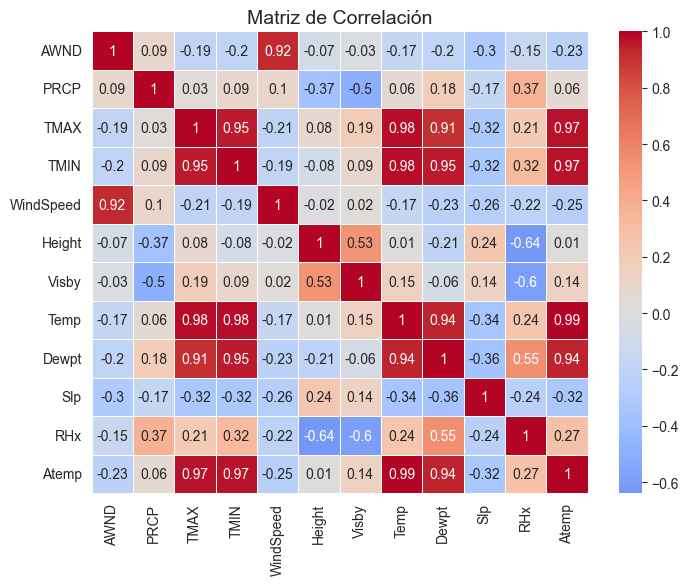

In [29]:
# Suponiendo que ya tienes tu matriz de correlaciones
corr = X[quant_predictors].to_pandas().corr().round(2)

plt.figure(figsize=(8,6))
sns.heatmap(corr, 
            annot=True,        # Muestra los valores dentro de cada celda
            cmap="coolwarm",   # Paleta de colores (azul-rojo)
            center=0,          # Centra el mapa en 0
            linewidths=0.5)    # Líneas entre celdas
plt.title("Matriz de Correlación", fontsize=14)
plt.show()


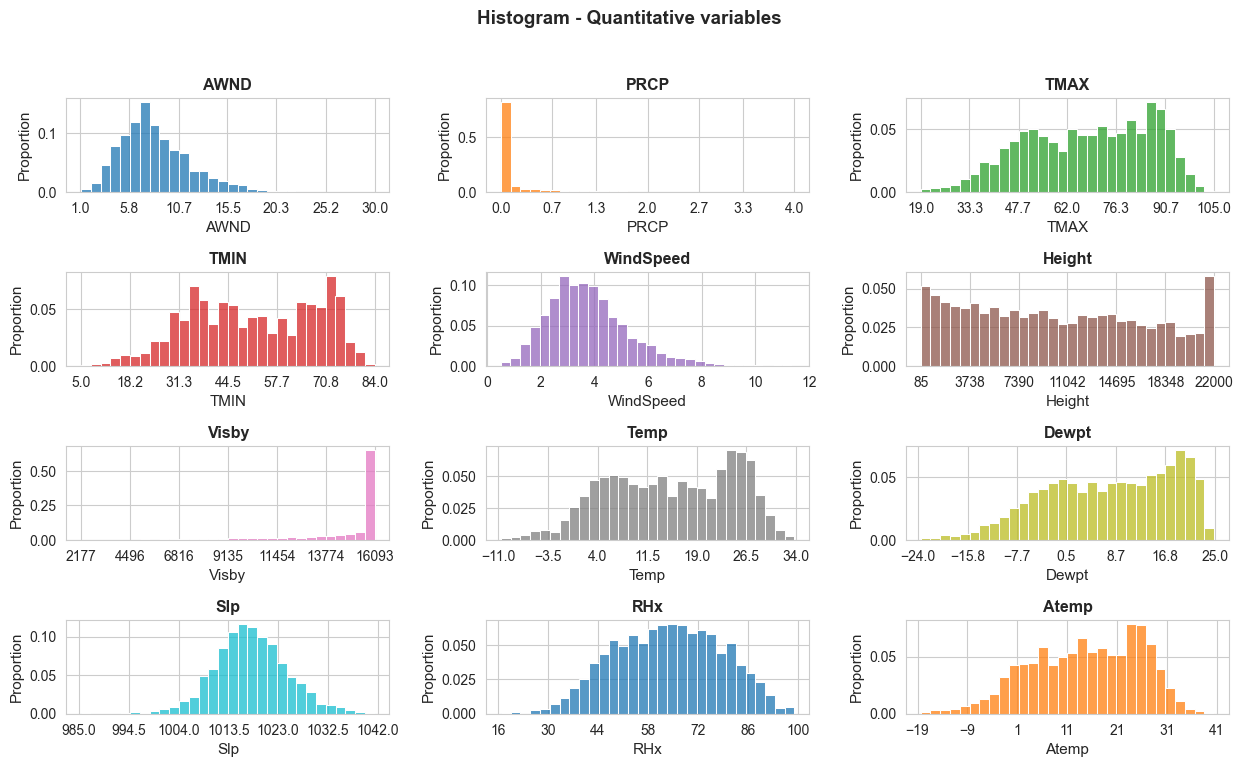

In [30]:
# Histogram
histogram_matrix(df=X, bins=30, n_cols=3, title='Histogram - Quantitative variables', 
                 figsize=(15,8), quant_col_names=quant_predictors, 
                 n_xticks=7, title_fontsize=13.5, 
                 subtitles_fontsize=11.5, save=False, file_name='', x_rotation=0, title_height=0.99,
                 style='whitegrid', hspace=0.85, wspace=0.3, n_round_xticks=1)

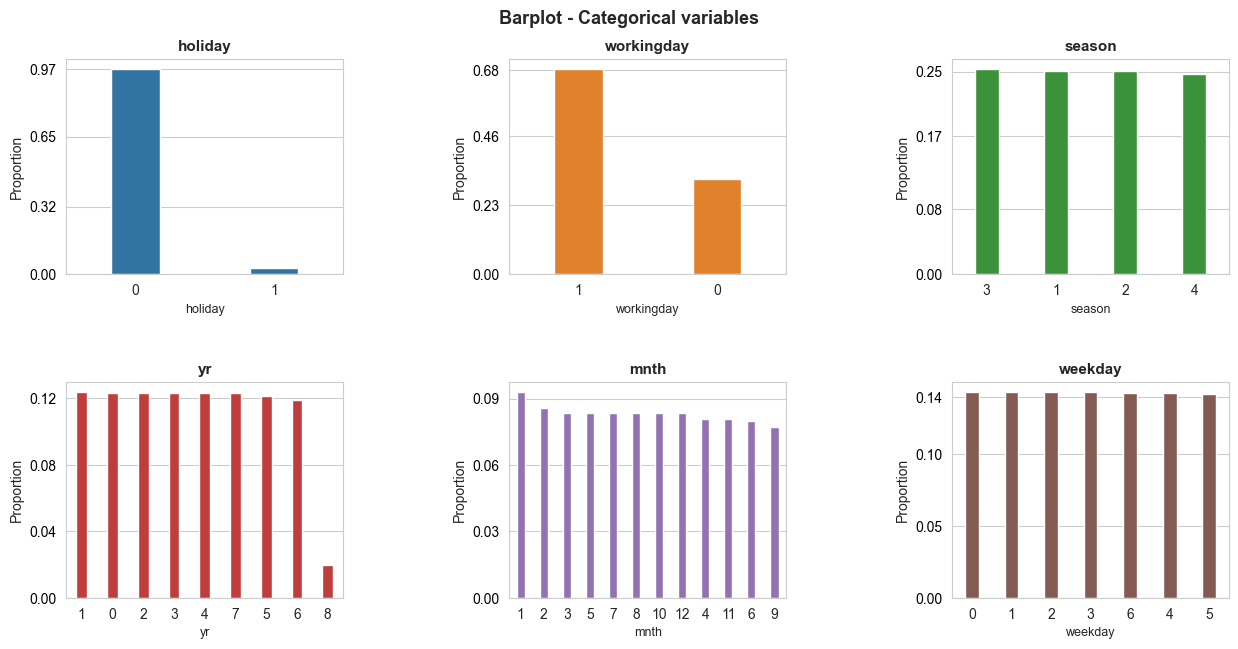

In [31]:
# Barplot
barplot_matrix(df=X, 
               n_cols=3, 
               title='Barplot - Categorical variables', 
               figsize=(15,7), 
               cat_col_names = binary_predictors + multiclass_predictors, 
               title_fontsize=13, 
               subtitles_fontsize=11, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.95,
               style='whitegrid', 
               hspace=0.5, 
               wspace=0.6, 
               title_weight='bold', 
               bar_width=0.35,
               ylabel_size=10, 
               xlabel_size=9, 
               xticks_size=10)

---


## Experiment 1


In [78]:
run_experiment_1 = True

In [79]:
if run_experiment_1: 
        
    n_realizations = 5
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 5
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_1', 'bikes')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20250930_130045'

    config_exp_1 = get_config_exp_1_bikes()
   
    config_exp_1.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

    if not isinstance(y, np.ndarray):
        y = y.to_numpy().flatten() # needed by adjusted_accuracy, which is used by make_experiment_1

In [80]:
if run_experiment_1: 

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks', position=0)):
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)
                
            results[random_state] = make_experiment_1(**config_exp_1,
                                                    X=X, 
                                                    y=y,
                                                    random_state=random_state,
                                                    metric=accuracy_score #balanced_accuracy_score
                                                )
            
        # Save results
        results_filename = f'results_exp_1_bikes_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 250 realizations: 41 mins

chunks:   0%|          | 0/1 [00:00<?, ?chunks/s]

random_state_chunk: [428, 2192, 714, 3336, 2183]
random_state: 428
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 2192
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 714
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_p

chunks: 100%|██████████| 1/1 [07:30<00:00, 450.20s/chunks]

len y_pred: 3


In [81]:
if run_experiment_1: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_1', 'bikes')
    file_id = '20250930_130045'
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_1_bikes_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_1_bikes_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [82]:
# Open merged/joined results 

file_id = '20250930_130045'
results_filename = f'results_exp_1_bikes_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_1', 'bikes')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [83]:
experiment_1_config = get_config_exp_1_bikes()

pivoted_results = get_pivoted_results(
    results=results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

In [84]:
frac_sample_sizes_list = np.array(list(avg_results['adj_accuracy'].keys()))
adj_accuracy_list = list(avg_results['adj_accuracy'].values())
ari_list = list(avg_results['ARI'].values())
time_list = list(avg_results['time'].values())
best_frac_sample_size = frac_sample_sizes_list[np.argmax(adj_accuracy_list)]

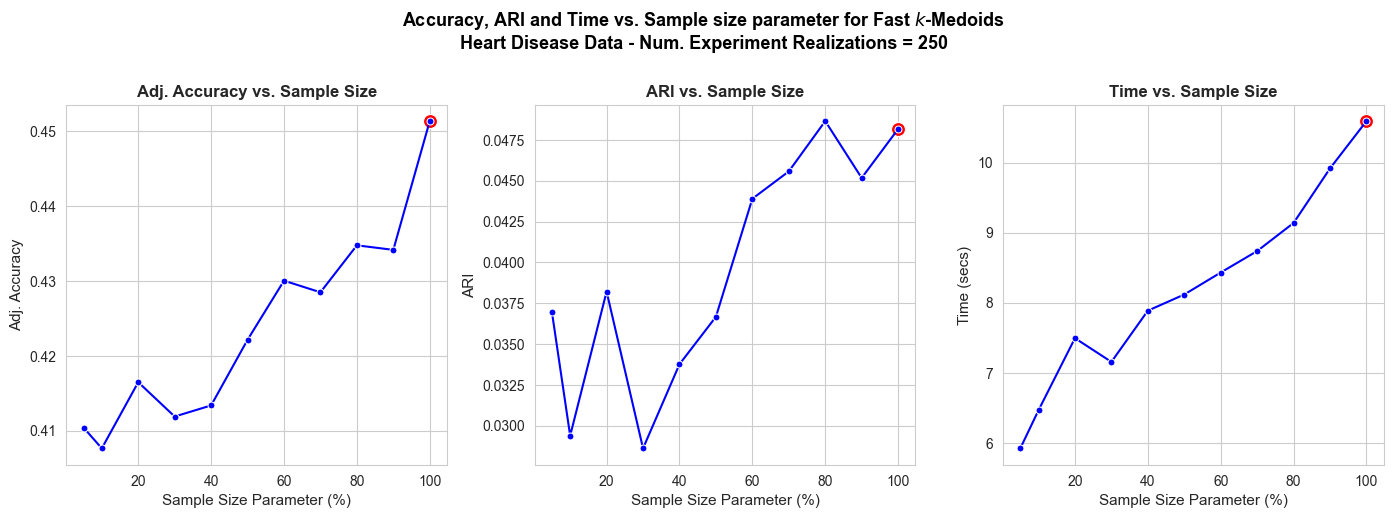

In [85]:
fig, axes = plt.subplots(1, 3, figsize=(17,5))
axes = axes.flatten()  

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['adj_accuracy'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[0])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=adj_accuracy_list, 
    color='blue', marker='o',  markersize=5, ax=axes[0]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['ARI'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[1])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=ari_list, 
    color='blue', marker='o',  markersize=5, ax=axes[1]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['time'][best_frac_sample_size]], color='red', marker='o', markersize=10, ax=axes[2])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=time_list, 
    color='blue', marker='o', markersize=5, ax=axes[2]
)

axes[0].set_title('Adj. Accuracy vs. Sample Size', size=12, weight='bold')
axes[0].set_ylabel('Adj. Accuracy', size=11)
#axes[0].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[1].set_title('ARI vs. Sample Size', size=12, weight='bold')
axes[1].set_ylabel('ARI', size=11)
#axes[1].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[2].set_title('Time vs. Sample Size', size=12, weight='bold')
axes[2].set_ylabel('Time (secs)', size=11)
#axes[2].set_yticks(np.round(np.linspace(np.min(times_values), np.max(times_values), 7),1))

for i in range(len(axes)):
    #axes[i].set_xticks(np.round(np.linspace(np.min(data_perc_sizes), np.max(data_perc_sizes), 7),1))
    axes[i].set_xlabel('Sample Size Parameter (%)', size=11)

#plt.tight_layout()
plt.subplots_adjust(top=0.83)
plt.suptitle('Accuracy, ARI and Time vs. Sample size parameter for Fast $k$-Medoids\nHeart Disease Data - Num. Experiment Realizations = 250', fontsize=13, y=1.02, weight='bold', color='black', alpha=1)
plt.subplots_adjust(hspace=0.5, wspace=0.23) 

plot_filename = f'plot_results_exp_1_bikes_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
if not os.path.exists(plot_save_path):
    fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [87]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'frac_sample_size'
avg_results_df

,time,adj_accuracy,ARI
frac_sample_size,,,
0.05,5.920416,0.410398,0.036946
0.10,6.464760,0.407630,0.029385
0.20,7.493660,0.416475,0.038211
0.30,7.155018,0.411884,0.028610
0.40,7.886541,0.413369,0.033761
0.50,8.117206,0.422147,0.036666
0.60,8.430969,0.430047,0.043895
0.70,8.737620,0.428494,0.045568
0.80,9.139028,0.434774,0.048649


In [88]:
print(best_frac_sample_size)

1.0



## Experiment 3


In [89]:
run_experiment_3 = True

In [90]:
if run_experiment_3: 

    n_realizations = 5
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_3', 'bikes')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20250930_155234'

    config_exp_3 = get_config_exp_3_bikes()
    
    config_exp_3.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

    if not isinstance(y, np.ndarray):
        y = y.to_numpy().flatten() # needed by adjusted_accuracy, which is used by make_experiment_1

In [92]:
if run_experiment_3: 

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks'), start=0):
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)    

            results[random_state] = make_experiment_3(**config_exp_3,
                                                    X=X, 
                                                    y=y,
                                                    random_state=random_state,
                                                    metric=accuracy_score #balanced_accuracy_score 
                                                )

        # Save results
        results_filename = f'results_exp_3_bikes_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 10 realizations: 50 mins

chunks:   0%|          | 0/2 [00:00<?, ?chunks/s]

random_state_chunk: [428, 2192, 714]
random_state: 428
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:12<00:00,  2.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:29<00:00,  5.99s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:28<00:00,  5.63s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:25<00:00,  5.17s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:26<00:00,  5.21s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:52<00:00,  5.22s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:53<00:00,  5.32s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:51<00:00,  5.19s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:50<00:00,  5.03s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:54<00:00,  5.46s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [01:28<00:00,  5.90s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:36<00:00,  2.44s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:26<00:00,  1.79s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:26<00:00,  1.79s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:26<00:00,  1.77s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:36<00:00,  1.83s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:36<00:00,  1.81s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:35<00:00,  1.79s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:37<00:00,  1.85s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:35<00:00,  1.77s/it]


random_state: 2192
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.99s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:26<00:00,  5.24s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:54<00:00,  5.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:54<00:00,  5.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:53<00:00,  5.39s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:50<00:00,  5.05s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:51<00:00,  5.19s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [01:16<00:00,  5.07s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [01:20<00:00,  5.34s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [01:24<00:00,  5.63s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [01:17<00:00,  5.16s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [01:14<00:00,  4.96s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [01:45<00:00,  5.25s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [01:52<00:00,  5.62s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:52<00:00,  2.60s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it]


random_state: 714
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:24<00:00,  2.42s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:33<00:00,  2.22s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:34<00:00,  2.28s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:33<00:00,  2.25s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:33<00:00,  2.24s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:32<00:00,  2.18s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:36<00:00,  1.81s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:35<00:00,  1.79s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:35<00:00,  1.79s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:35<00:00,  1.78s/it]


frac_sample_size: 1.0


chunks:  50%|█████     | 1/2 [42:07<42:07, 2527.03s/chunks]

random_state_chunk: [3336, 2183]
random_state: 3336
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:22<00:00,  2.22s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:23<00:00,  2.32s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:21<00:00,  2.16s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:23<00:00,  2.38s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:32<00:00,  2.19s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:33<00:00,  2.25s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:33<00:00,  2.20s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:31<00:00,  2.13s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:43<00:00,  2.15s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:44<00:00,  2.24s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:43<00:00,  2.16s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:42<00:00,  2.13s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:44<00:00,  2.21s/it]


random_state: 2183
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:12<00:00,  2.43s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:22<00:00,  2.23s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:22<00:00,  2.21s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:22<00:00,  2.24s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:22<00:00,  2.24s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:23<00:00,  2.36s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:34<00:00,  2.28s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:32<00:00,  2.20s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:32<00:00,  2.19s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:32<00:00,  2.15s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:44<00:00,  2.24s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:43<00:00,  2.18s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:45<00:00,  2.28s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:42<00:00,  2.12s/it]


frac_sample_size: 1.0


chunks: 100%|██████████| 2/2 [1:01:54<00:00, 1857.23s/chunks]


In [95]:
if run_experiment_3: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    file_id = '20250930_155234'
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_3_bikes_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_3_bikes_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [96]:
# Open merged/joined results 

file_id = '20250930_155234'
results_filename = f'results_exp_3_bikes_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_3', 'bikes')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [97]:
config_exp_3 = get_config_exp_3_bikes()

pivoted_results = get_pivoted_results_two_iterables(results = results, 
                                  iterable1 = config_exp_3['n_splits'], 
                                  iterable2 = config_exp_3['frac_sample_sizes'])

avg_results = get_avg_results_two_iterables(results = results, 
                                  pivoted_results = pivoted_results, 
                                  iterable1 = config_exp_3['n_splits'], 
                                  iterable2 = config_exp_3['frac_sample_sizes'])

dfs = avg_results_to_dfs(avg_results, column_1='n_splits', column_2='frac_sample_sizes')

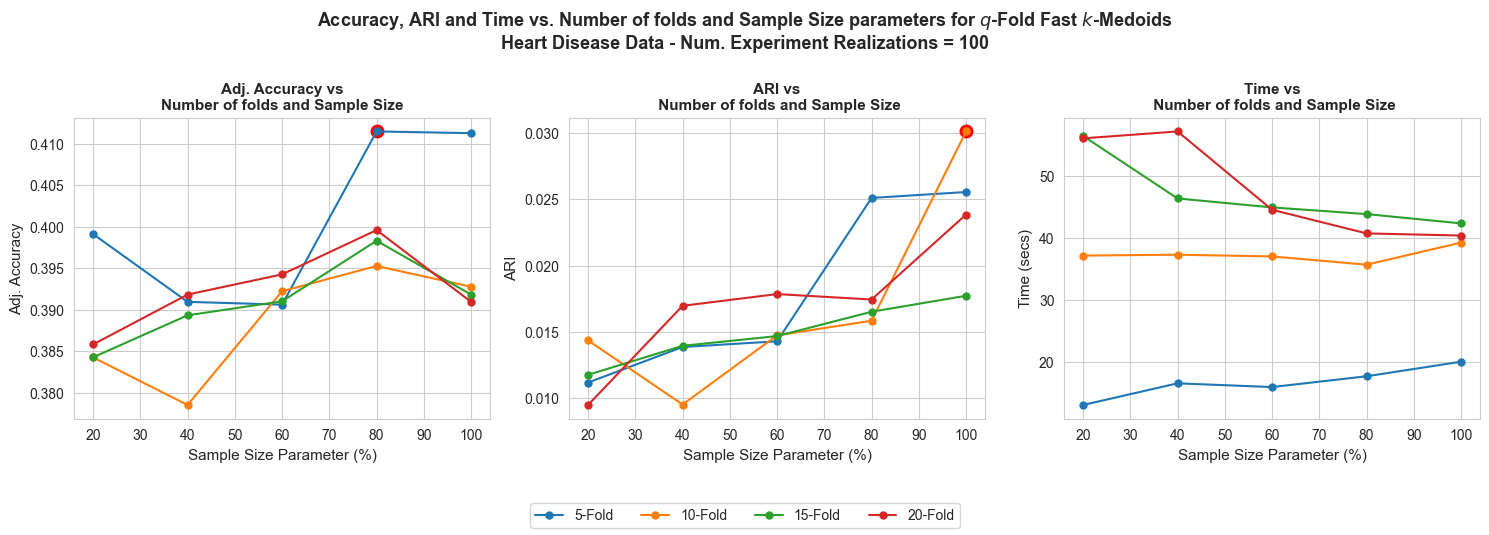

In [98]:
best_combi_acc = dfs['adj_accuracy'].sort_values(by='adj_accuracy', ascending=False).iloc[0]
best_combi_ari = dfs['ARI'].sort_values(by='ARI', ascending=False).iloc[0]
best_combi_time = dfs['time'].sort_values(by='time', ascending=True).iloc[0]

fig, axes = plt.subplots(1, 3, figsize=(15, 5.5), sharex=True)

# Primer subplot: Accuracy
ax1 = axes[0]
ax1.plot(best_combi_acc['frac_sample_sizes'] * 100, best_combi_acc['adj_accuracy'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['adj_accuracy']['n_splits'].unique()):
    subset = dfs['adj_accuracy'][dfs['adj_accuracy']['n_splits'] == k1]
    ax1.plot(subset['frac_sample_sizes'] * 100, subset['adj_accuracy'], marker='o', markersize=5, label=f"{k1}-Fold")
ax1.set_title("Adj. Accuracy vs\nNumber of folds and Sample Size", fontsize=11, fontweight='bold')
ax1.set_xlabel("Sample Size Parameter (%)", size=11)
ax1.set_ylabel("Adj. Accuracy", size=11)

# Segundo subplot: Accuracy
ax2 = axes[1]
ax2.plot(best_combi_ari['frac_sample_sizes'] * 100, best_combi_ari['ARI'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['ARI']['n_splits'].unique()):
    subset = dfs['ARI'][dfs['ARI']['n_splits'] == k1]
    ax2.plot(subset['frac_sample_sizes'] * 100, subset['ARI'], marker='o', markersize=5, label=f"{k1}-Fold")
ax2.set_title("ARI vs\n Number of folds and Sample Size", fontsize=11, fontweight='bold')
ax2.set_xlabel("Sample Size Parameter (%)", size=11)
ax2.set_ylabel("ARI", size=11)

# Tercer subplot: Time
ax3 = axes[2]
#ax3.plot(best_combi_time['frac_sample_sizes'] * 100, best_combi_time['time'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['time']['n_splits'].unique()):
    subset = dfs['time'][dfs['time']['n_splits'] == k1]
    ax3.plot(subset['frac_sample_sizes'] * 100, subset['time'], marker='o', markersize=5, label=f"{k1}-Fold")
ax3.set_title("Time vs\n Number of folds and Sample Size", fontsize=11, fontweight='bold')
ax3.set_xlabel("Sample Size Parameter (%)", size=11)
ax3.set_ylabel("Time (secs)", size=11)

# Título general
fig.suptitle("Accuracy, ARI and Time vs. Number of folds and Sample Size parameters for $q$-Fold Fast $k$-Medoids\nHeart Disease Data - Num. Experiment Realizations = 100", fontsize=13, fontweight='bold', y=0.95)

# Leyenda común abajo
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize=10)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])

plot_filename = f'plot_results_exp_3_bikes_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [99]:
# Results as table
avg_results_df = pd.concat([dfs['adj_accuracy'], dfs['ARI']['ARI'], dfs['time']['time']], axis=1)
avg_results_df

,n_splits,frac_sample_sizes,adj_accuracy,ARI,time
0,5,0.2,0.399122,0.011161,13.108961
1,5,0.4,0.390952,0.013847,16.596750
2,5,0.6,0.390614,0.014277,15.994625
3,5,0.8,0.411479,0.025108,17.732780
4,5,1.0,0.411276,0.025554,20.077192
5,10,0.2,0.384267,0.014346,37.162907
6,10,0.4,0.378528,0.009503,37.301969
7,10,0.6,0.392235,0.014727,37.025449
8,10,0.8,0.395273,0.015831,35.696701
9,10,1.0,0.392775,0.030130,39.250958


In [100]:
n = len(X)
split_ratio = np.round((best_combi_acc['n_splits']/n)*100,3) # best_split = split_ratio * n

print(' split_ratio', split_ratio, '\n', 'best_n_splits', best_combi_acc['n_splits'], '\n', 'best_frac_sample_size', best_combi_acc['frac_sample_sizes'])

 split_ratio 0.169 
 best_n_splits 5.0 
 best_frac_sample_size 0.8



## Experiment 4

In [32]:
config_exp_4 = get_config_exp_4_bikes()
    
config_exp_4.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

if not isinstance(y, np.ndarray):
    y = y.to_numpy().flatten() # needed by adjusted_accuracy, which is used by make_experiment_4

quant_distances_names = ['robust_mahalanobis']
binary_distances_names = ['jaccard', 'sokal']
multiclass_distances_names = ['hamming']
robust_method = ['MAD', 'trimmed', 'winsorized']

GGower_distances_names = get_GGower_distances_names(quant_distances_names, binary_distances_names, multiclass_distances_names, robust_method)

#################################################################################################

# With real data the realizations cannot operate over the randomness of the data
# An alternative approach is to operate over the randomness of the models.

models = {}
n_realizations = 5
experiment_random_state = 123 
random.seed(experiment_random_state)
random_state_list = random.sample(range(n_realizations*1000), n_realizations)

for random_state in random_state_list:


    models[random_state] = {
        
        'KMeans': KMeans(
            n_clusters=config_exp_4['n_clusters'], 
            random_state=random_state, 
            init='k-means++', 
            n_init='auto', 
            max_iter=config_exp_4['max_iter']),

        'CLARA': CLARA(n_clusters=config_exp_4['n_clusters'], 
                       metric='euclidean',
                       random_state=random_state),

        'Diana': Diana(n_clusters=config_exp_4['n_clusters']),

        'LDAKmeans': LDAKmeans(n_clusters=config_exp_4['n_clusters'], random_state=random_state,),

        'SubKmeans': SubKmeans(n_clusters=config_exp_4['n_clusters']),

        'GaussianMixture': GaussianMixture(n_components=config_exp_4['n_clusters'], 
                                           random_state=random_state),

        'AgglomerativeClustering': AgglomerativeClustering(n_clusters=config_exp_4['n_clusters']),

        'SpectralBiclustering': SpectralBiclustering(n_clusters=config_exp_4['n_clusters'], random_state=random_state),

        'SpectralCoclustering': SpectralCoclustering(n_clusters=config_exp_4['n_clusters'], random_state=random_state),

        'Birch': Birch(n_clusters=config_exp_4['n_clusters']),

        'BisectingKMeans': BisectingKMeans(n_clusters=config_exp_4['n_clusters'], 
                                        random_state=random_state, 
                                        max_iter=config_exp_4['max_iter']),

        'MiniBatchKMeans': MiniBatchKMeans(n_clusters=config_exp_4['n_clusters'], 
                                        random_state=random_state, 
                                        max_iter=config_exp_4['max_iter']),

        'KMedoids-euclidean': KMedoids(n_clusters=config_exp_4['n_clusters'], 
                                    metric='euclidean', 
                                    method=config_exp_4['method'], 
                                    init=config_exp_4['init'], 
                                    max_iter=config_exp_4['max_iter'], 
                                    random_state=random_state),
    }

    #################################################################################################

    for d in GGower_distances_names:

        d1, d2, d3 = d.split('-')

        if 'robust' in d1:
            r = d1.split('_')[-1]
            d1 = '_'.join(d1.split('_')[:2])
            label_model_name = f'{d1}_{r}-{d2}-{d3}'
        else:
            r = None
            label_model_name = f'{d1}-{d2}-{d3}'
            
        models[random_state][f'FastKmedoidsGGower-{label_model_name}'] = FastKmedoidsGGower(
                n_clusters=config_exp_4['n_clusters'], 
                method=config_exp_4['method'], 
                init=config_exp_4['init'], 
                max_iter=config_exp_4['max_iter'], 
                random_state=random_state,
                frac_sample_size=config_exp_4['frac_sample_size_fast_kmedoids'], 
                p1=config_exp_4['p1'], 
                p2=config_exp_4['p2'], 
                p3=config_exp_4['p3'], 
                d1=d1, 
                d2=d2, 
                d3=d3, 
                q=1,
                robust_method=r, 
                alpha=config_exp_4['alpha'], 
                epsilon=config_exp_4['epsilon'], 
                n_iters=config_exp_4['n_iters'],
                VG_sample_size=config_exp_4['VG_sample_size'], 
                VG_n_samples=config_exp_4['VG_n_samples']) 

        models[random_state][f'FoldFastKmedoidsGGower-{label_model_name}'] = FoldFastKmedoidsGGower(
                n_clusters=config_exp_4['n_clusters'], 
                method=config_exp_4['method'], 
                init=config_exp_4['init'], 
                max_iter=config_exp_4['max_iter'], 
                random_state=random_state,
                frac_sample_size=config_exp_4['frac_sample_size_fold_fast_kmedoids'], 
                p1=config_exp_4['p1'], 
                p2=config_exp_4['p2'], 
                p3=config_exp_4['p3'], 
                d1=d1, 
                d2=d2, 
                d3=d3, 
                q=1,
                robust_method=r, 
                alpha=config_exp_4['alpha'], 
                epsilon=config_exp_4['epsilon'], 
                n_iters=config_exp_4['n_iters'],
                VG_sample_size=config_exp_4['VG_sample_size'], 
                VG_n_samples=config_exp_4['VG_n_samples'],
                n_splits=config_exp_4['n_splits'], 
                shuffle=config_exp_4['shuffle'], 
                kfold_random_state=random_state) 

In [33]:
run_experiment_4 = True

In [35]:
if run_experiment_4: 

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_4', 'bikes')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20251001_121615'

    X_pd = X.to_pandas() # Some models like LDAKmeans expect Pandas

In [28]:
if run_experiment_4: 
 
    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks'), start=0):
        print('chunk_id', chunk_id)
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)        
            
            results[random_state] = make_experiment_4(
                X=X_pd, 
                y=y, 
                models=models[random_state],
                metric=accuracy_score#balanced_accuracy_score  
                )

        # Save results
        results_filename = f'results_exp_4_bikes_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 5 realizations: 20 mins

chunks:   0%|          | 0/2 [00:00<?, ?chunks/s]

chunk_id 0
random_state_chunk: [428, 2192, 714]
random_state: 428
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


len y_pred: 3
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]


len y_pred: 3
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


len y_pred: 3
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


len y_pred: 3
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


len y_pred: 3
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


len y_pred: 3
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]


len y_pred: 3
random_state: 2192
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it]


len y_pred: 3
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


len y_pred: 3
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]


len y_pred: 3
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]


len y_pred: 3
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


len y_pred: 3
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


len y_pred: 3
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


len y_pred: 3
random_state: 714
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


len y_pred: 3
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]


len y_pred: 3
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]


len y_pred: 3
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]


len y_pred: 3
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]


len y_pred: 3
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]


len y_pred: 3
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-minkowski-sokal-hamming


chunks:  50%|█████     | 1/2 [06:48<06:48, 408.18s/chunks]

len y_pred: 3
chunk_id 1
random_state_chunk: [3336, 2183]
random_state: 3336
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:12<00:00,  2.43s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:12<00:00,  2.46s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:12<00:00,  2.49s/it]


len y_pred: 3
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


len y_pred: 3
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


len y_pred: 3
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]


len y_pred: 3
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]


len y_pred: 3
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]


len y_pred: 3
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]


len y_pred: 3
random_state: 2183
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:12<00:00,  2.42s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:12<00:00,  2.41s/it]


len y_pred: 3
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


len y_pred: 3
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]


len y_pred: 3
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


len y_pred: 3
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]


len y_pred: 3
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


len y_pred: 3
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-minkowski-sokal-hamming


chunks: 100%|██████████| 2/2 [11:41<00:00, 350.94s/chunks]

len y_pred: 3


In [36]:
if run_experiment_4: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'bikes')
    file_id = '20251001_121615'
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_4_bikes_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_4_bikes_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [37]:
# Open merged/joined results 

file_id = '20251001_121615'
results_filename = f'results_exp_4_bikes_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'bikes')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [38]:
model_names = list(models[random_state_list[0]].keys())

pivoted_results = get_pivoted_results(
    results=results, 
    iterable=model_names
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=model_names
)

In [44]:
not_feasible_methods = [] 

for model_name in not_feasible_methods:
    avg_results['adj_labels'][model_name] = None
    avg_results['labels'][model_name] = None
    avg_results['adj_accuracy'][model_name] = 0
    avg_results['ARI'][model_name] = 0
    avg_results['time'][model_name] = 0

model_names = np.array(list(avg_results['adj_accuracy'].keys()))
avg_adj_accuracy = np.array(list(avg_results['adj_accuracy'].values()))
avg_ari = np.array(list(avg_results['ARI'].values()))
avg_time = np.array(list(avg_results['time'].values()))
#idx_sorted = np.argsort(-avg_adj_accuracy) 
idx_sorted = np.argsort(-avg_ari) 

our_methods_1 = [x for x in model_names if 'Fast' in x and 'Fold' not in x] # Fast k-medoids
our_methods_2 = [x for x in model_names if 'Fast' in x and 'Fold' in x] # q-Fold Fast k-medoids
other_methods = [x for x in model_names if x not in our_methods_1 + our_methods_2 and x not in not_feasible_methods]

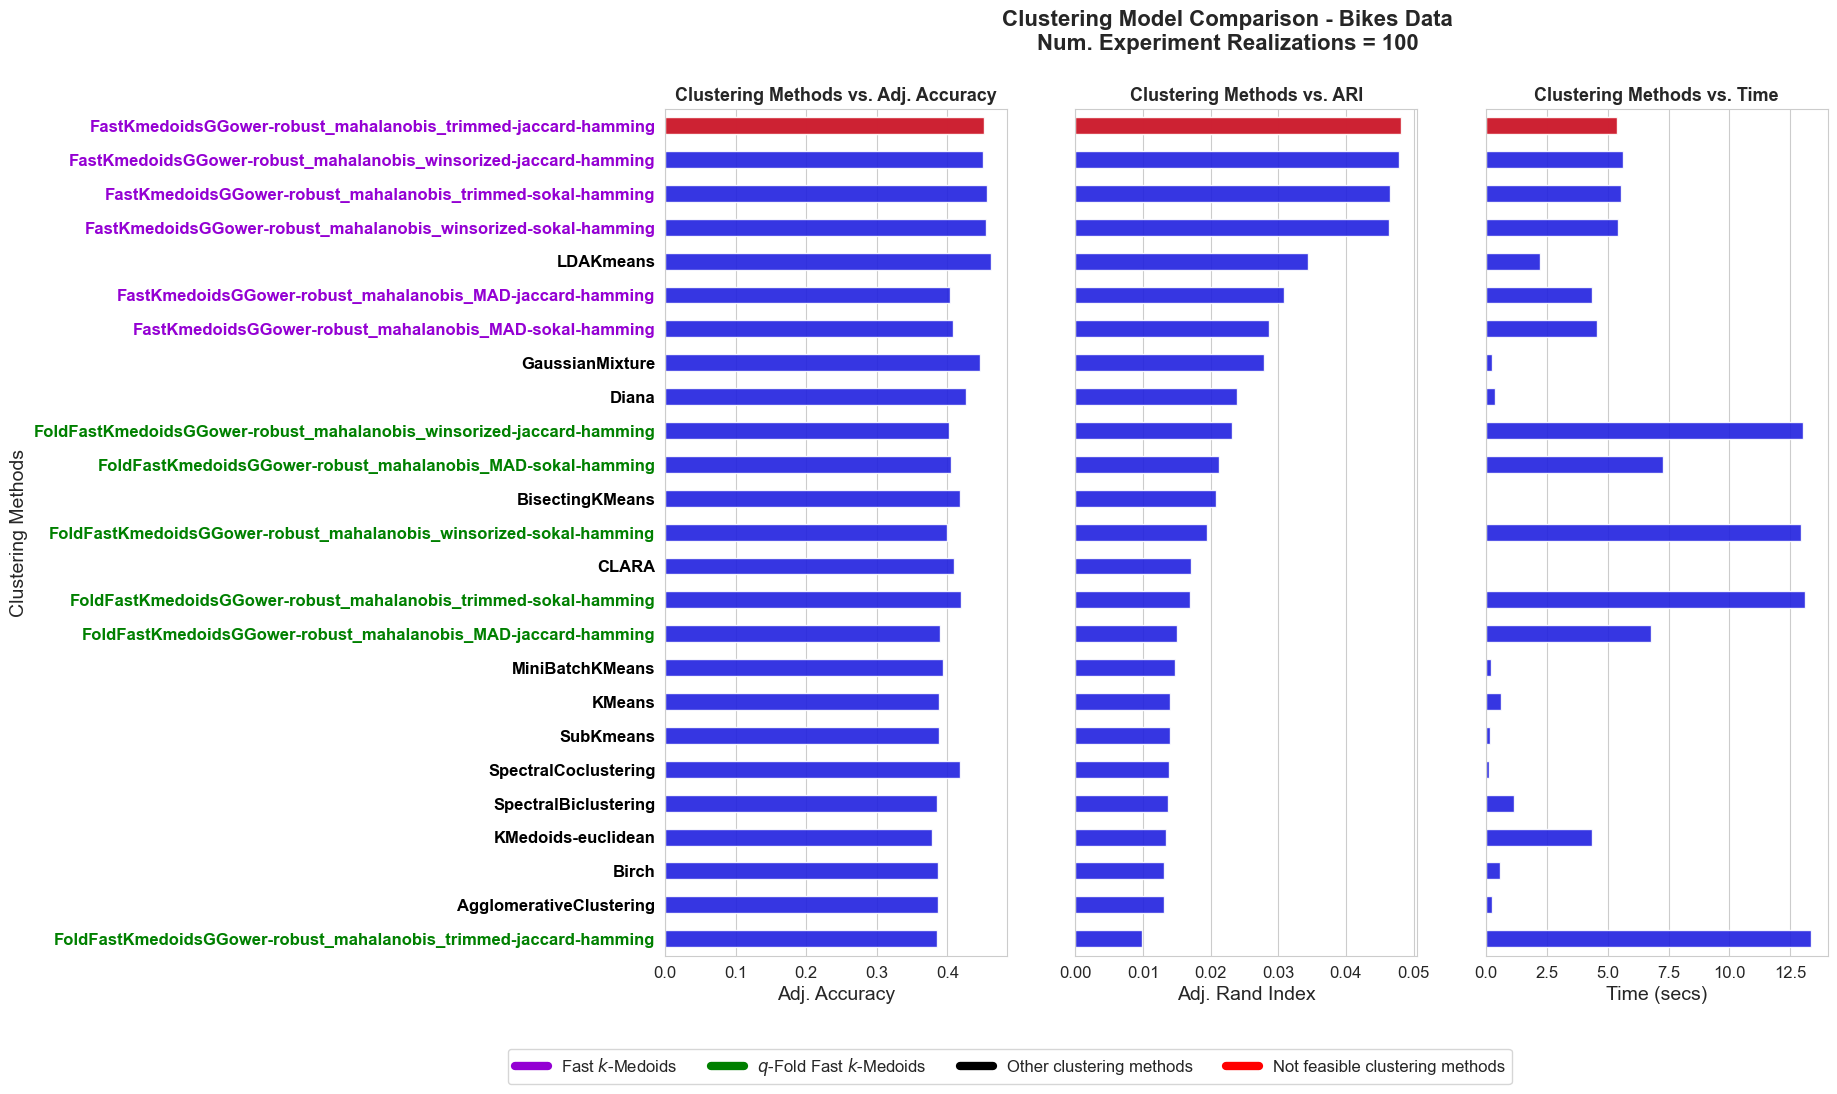

In [45]:
fig, axes = plt.subplots(1,3, figsize=(15,11))
axes = axes.flatten()

ax = sns.barplot(x=avg_adj_accuracy[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[0])
ax = sns.barplot(x=[avg_adj_accuracy[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[0])

ax = sns.barplot(x=avg_ari[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[1])
ax = sns.barplot(x=[avg_ari[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[1])

ax = sns.barplot(x=avg_time[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[2])
ax = sns.barplot(x=[avg_time[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[2])

axes[0].set_ylabel('Clustering Methods', size=14)
axes[0].set_xlabel('Adj. Accuracy', size=14)
#axes[0].set_xticks(np.round(np.linspace(0, np.max(accuracy_list), 7),2)) 
axes[0].tick_params(axis='y', labelsize=12)    
axes[0].tick_params(axis='x', labelsize=12)  
axes[0].set_title('Clustering Methods vs. Adj. Accuracy', size=13, weight='bold')

axes[1].set_xlabel('Adj. Rand Index', size=14)
#axes[1].set_xticks(np.round(np.linspace(0, np.max(adj_rand_index_list), 7),2)) 
axes[1].tick_params(axis='x', labelsize=12)  
axes[1].set_title('Clustering Methods vs. ARI', size=13, weight='bold')
axes[1].set_yticklabels([])

axes[2].set_xlabel('Time (secs)', size=14)
#axes[2].set_xticks(np.round(np.linspace(0, np.max(time_list), 7),2)) 
axes[2].tick_params(axis='x', labelsize=12)  
axes[2].set_title('Clustering Methods vs. Time', size=13, weight='bold')
axes[2].set_yticklabels([])

for label in axes[0].get_yticklabels():
    if label.get_text() in our_methods_1:
        label.set_weight('bold')
        label.set_color('darkviolet') 
    elif label.get_text() in our_methods_2:
        label.set_weight('bold')
        label.set_color('green') 
    elif label.get_text() in other_methods:
        label.set_weight('bold')
        label.set_color('black') 
    elif label.get_text() in not_feasible_methods:
        label.set_weight('bold')
        label.set_color('red') 

# Create legend elements
legend_elements = [
    plt.Line2D([0], [0], color='darkviolet', lw=6, label='Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='green', lw=6, label='$q$-Fold Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='black', lw=6, label='Other clustering methods'),
    plt.Line2D([0], [0], color='red', lw=6, label='Not feasible clustering methods')
]

# Add legend to the figure
axes[0].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(2.5, -0.1), ncol=len(legend_elements), fontsize=12)

fig.suptitle("Clustering Model Comparison - Bikes Data\nNum. Experiment Realizations = 100", fontsize=16, fontweight='bold', y=0.97)

plot_filename = f'plot_results_exp_4_bikes_{file_id}_ari.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [46]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'models'
avg_results_df = avg_results_df.drop(['labels', 'adj_labels'], axis=1)
avg_results_df_sorted_acc = avg_results_df.sort_values(by='adj_accuracy', ascending=False)
avg_results_df_sorted_ari = avg_results_df.sort_values(by='ARI', ascending=False)

In [47]:
avg_results_df_sorted_acc

,time,adj_accuracy,ARI
models,,,
LDAKmeans,2.244158,0.461512,0.034430
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,5.558553,0.455773,0.046588
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,5.408245,0.455098,0.046342
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming,5.381192,0.451384,0.048162
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming,5.616879,0.450371,0.047786
GaussianMixture,0.269997,0.445645,0.027854
Diana,0.370499,0.426739,0.023891
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,13.100799,0.419784,0.016987
SpectralCoclustering,0.121704,0.418298,0.013867


In [48]:
avg_results_df_sorted_ari

,time,adj_accuracy,ARI
models,,,
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming,5.381192,0.451384,0.048162
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming,5.616879,0.450371,0.047786
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,5.558553,0.455773,0.046588
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,5.408245,0.455098,0.046342
LDAKmeans,2.244158,0.461512,0.034430
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming,4.365365,0.403781,0.030835
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming,4.564651,0.408508,0.028647
GaussianMixture,0.269997,0.445645,0.027854
Diana,0.370499,0.426739,0.023891


In [49]:
random_state_mds = 428

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=random_state_mds) 

fastGG = FastGGowerDistMatrix(frac_sample_size=0.4, random_state=random_state_mds, p1=p1, p2=p2, p3=p3, 
                 d1='robust_mahalanobis', d2='sokal', d3='hamming', 
                 robust_method='winsorized', alpha=0.05)

fastGG.compute(X)

X_mds = mds.fit_transform(fastGG.D_GGower)

c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [50]:
#outliers_bool = np.array([0 if x not in outliers_idx else 1 for x in range(0, len(X))])

sorted_methods_accuracy = list(avg_results_df_sorted_acc.index)

our_methods_1_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_1]
our_methods_2_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_2]
other_methods_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in other_methods]
best_our_methods_1 = our_methods_1_sorted_acc[0]
best_our_methods_2 = our_methods_2_sorted_acc[0]
best_other_methods = other_methods_sorted_acc[0]
additional_methods = ['KMeans', 'GaussianMixture']

methods_to_plot = [best_our_methods_1, best_our_methods_2, best_other_methods] + additional_methods
names_to_plot = [('Best Fast k-medoids' if x in our_methods_1 else 'Best q-Fold Fast k-medoids' if x in our_methods_2 else x) for x in methods_to_plot]
names_to_plot = dict(zip(methods_to_plot, names_to_plot))
y_pred_dict = {names_to_plot[method]: results[random_state_mds]['adj_labels'][method][fastGG.sample_index] for method in methods_to_plot}
accuracy_dict = {names_to_plot[method]: results[random_state_mds]['adj_accuracy'][method] for method in methods_to_plot}
time_dict = {names_to_plot[method]: results[random_state_mds]['time'][method] for method in methods_to_plot}

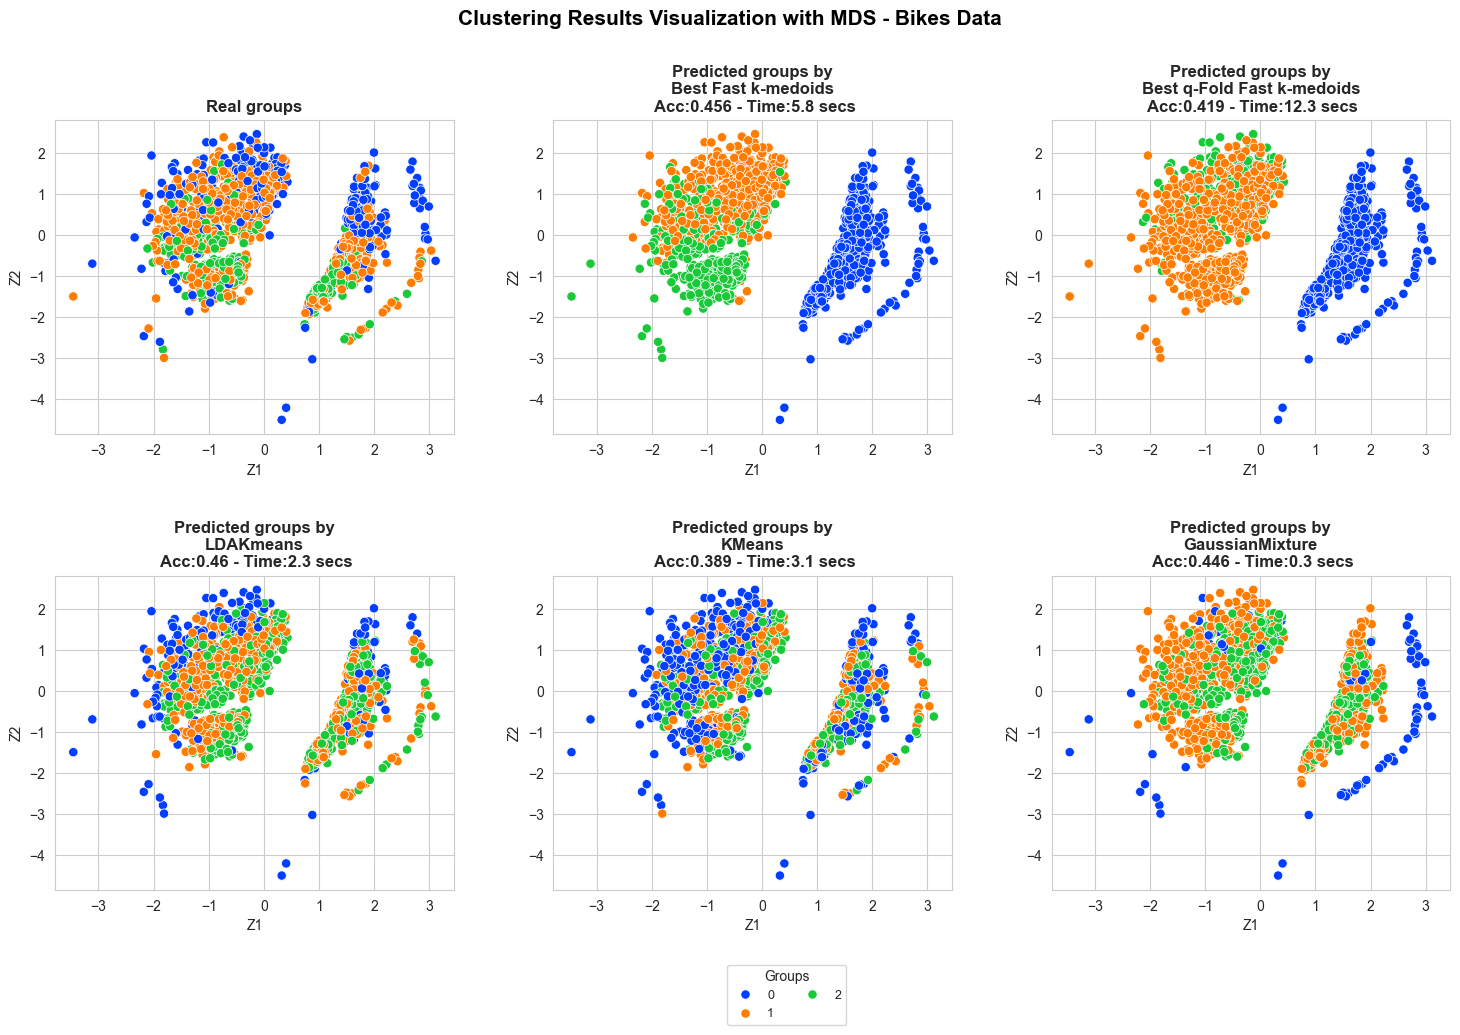

In [51]:
plot_filename = f'mds_plot_exp_4_bikes_{file_id}.png'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'bikes')
plot_save_path = os.path.join(results_folder_path, plot_filename)

clustering_MDS_plot_multiple_methods(X_mds=X_mds, y_pred=y_pred_dict, 
                                     y_true=y[fastGG.sample_index],
                                     title=f"Clustering Results Visualization with MDS - Bikes Data", 
                                     accuracy=accuracy_dict, time=time_dict, n_rows=2,
                                     figsize=(18,10), bbox_to_anchor=(0.75,-1.9), 
                                     title_size=15, title_weight='bold', 
                                     subtitles_size=12,
                                     points_size=45, title_height=0.99, 
                                     wspace=0.25, hspace=0.45, 
                                     outliers_boolean=None, #outliers_bool[fastGG.sample_index],
                                     n_cols_legend=2, legend_title='Groups', legend_size=9, 
                                     save = True, file_name = plot_save_path
)

**TO DO**
- Probar resultados con balanced acc 
- Probar resultados con 2 clusters en vez de 3
- Meter ncluster como parte del output en el processing de todos los real data